In [9]:
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
import cv2
import numpy as np
import random
import math
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,random_split
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import cv2
from skimage import io

In [10]:
def transform_img2pc(img):
    img = np.mean(img, axis=2)
    img_array = np.asarray(img)
    indices = np.argwhere(img_array > 150)
    return indices.astype(np.float32)

In [11]:
dataset = CIFAR10(root='./data', train=True, download=True)
len_points = []
for idx in range(len(dataset)):
    img,label = dataset[idx]
    pc = transform_img2pc(img)
    len_points.append(len(pc))

Files already downloaded and verified


In [12]:
!mkdir figures

A subdirectory or file figures already exists.


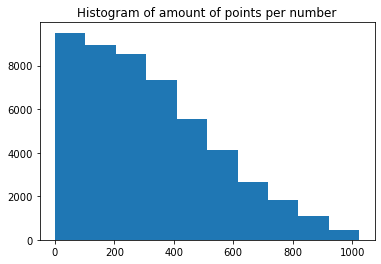

In [13]:
h = plt.hist(len_points)
plt.title('Histogram of amount of points per number')
plt.savefig('figures/Grayscale_CIFAR/histogram_points_minst.png',dpi=100)

In [14]:
count = 0
for i in len_points:
    if i == 0:
      count += 1
print(count)    

584


In [15]:
class CIFAR2D(Dataset):
    """2d CIFAR dataset."""
    
    NUM_CLASSIFICATION_CLASSES = 10
    POINT_DIMENSION = 3

    def __init__(self, dataset, num_points=800):
        self.dataset = dataset
        self.number_of_points = num_points

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        img,label = dataset[idx]
        pc = transform_img2pc(img)

        if self.number_of_points-pc.shape[0]>0:
            # repeat some points to reach uniform number of points
            sampling_indices = np.random.choice(pc.shape[0], self.number_of_points-pc.shape[0])
            new_points = pc[sampling_indices, :]
            pc = np.concatenate((pc, new_points),axis=0)
        else:
            sampling_indices = np.random.choice(pc.shape[0], self.number_of_points)
            pc = pc[sampling_indices, :]
            
        pc = pc.astype(np.float32)
        
        return pc, label

In [16]:
## Hyperparameters

dataset='CIFAR2D'
number_of_points=800
batch_size=128
learning_rate=0.001
number_of_workers=0

In [17]:
## Dataloaders

train_dataset = CIFAR10(root='./data/CIFAR10', download=True, train=True)
test_dataset = CIFAR10(root='./data/CIFAR10', download=True, train=False)
dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

dataset_3d = CIFAR2D(dataset, number_of_points)
l_data = len(dataset_3d)
train_dataset, val_dataset, test_dataset = random_split(dataset_3d,
                                          [round(0.8*l_data), round(0.1*l_data), round(0.1*l_data)],
                                          generator=torch.Generator().manual_seed(1))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR10\cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


In [18]:
class Tnet(nn.Module):
    def __init__(self, k=2):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
       

    def forward(self, input):
        # input.shape == (bs,n,2)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix


class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=2)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(2,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
    def forward(self, input):
        matrix2x2 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix2x2).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix2x2, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix2x2, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix2x2, matrix64x64

In [19]:
def pointnetloss(outputs, labels, m2x2, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id2x2 = torch.eye(2, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id2x2=id2x2.cuda()
        id64x64=id64x64.cuda()
    diff2x2 = id2x2-torch.bmm(m2x2,m2x2.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff2x2)+torch.norm(diff64x64)) / float(bs)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [21]:
pointnet = PointNet()
pointnet.to(device);

In [22]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.01)

In [23]:
def train(model, train_loader, val_loader=None,  epochs= 5, save=True):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs, m2x2, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m2x2, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_dataloader:
                    inputs, labels = data
                    if torch.cuda.is_available():
                        inputs, labels = inputs.cuda(), labels.cuda()
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(pointnet.state_dict(), "save_"+str(epoch)+".pth")

In [24]:
train(pointnet, train_dataloader, val_dataloader,  save=False)

ValueError: a must be greater than 0 unless no samples are taken